In [1]:
import torch
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
from model import SimpleLSTM, SpacedLSTM
from lstm_functions import quantile_loss, predict_model, plot_forecasts, plot_training_validation_loss
from data_prep import prepare_data

In [2]:
file_path = '../formatted_data/formatted_data_new.csv'
future_cols = ["Demand", "Wind_Generation", "PV_Generation", "Wind_Prediction", "Predicted_Demand_Renewables", "Hour_Sin", "Hour_Cos", "Day_Sin", "Day_Cos", "Month_Sin", "Month_Cos", "Predicted_Demand"]
quantiles = [0.2, 0.5, 0.8]

# Simple Benchmark Model

In [3]:

dense_lookback = 48  # Last 48 hours
forecast_horizon = 24  # Predict next 24 hours
target_col = "DA"


In [4]:
# Prepare datasets
(
    train_dense_past,
    train_future,
    train_pca,
    train_targets,
    val_dense_past,
    val_future,
    val_pca,
    val_targets,
    test_dense_past,
    test_future,
    test_pca,
    test_targets,
    target_scaler,
) = prepare_data(
    file_path=file_path,
    dense_lookback=dense_lookback,
    spaced_lookback=0,
    forecast_horizon=forecast_horizon,
    future_cols=future_cols,
    target_col=target_col,
    spaced=False,
)
print(train_dense_past.shape, train_future.shape, train_pca.shape, train_targets.shape)
# Create DataLoaders
train_loader = DataLoader(
    TensorDataset(train_dense_past, train_future, train_pca, train_targets),
    batch_size=64,
    shuffle=True,
)
val_loader = DataLoader(
    TensorDataset(val_dense_past, val_future, val_pca, val_targets),
    batch_size=64,
    shuffle=False,
)
test_loader = DataLoader(
    TensorDataset(test_dense_past, test_future, test_pca, test_targets),
    batch_size=1,
    shuffle=False,
)

# Initialize model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model1 = SimpleLSTM(
    past_input_size=train_dense_past.shape[2],
    future_input_size=len(future_cols),
    pca_input_size=train_pca.shape[1],
    hidden_size=128,
    num_layers=2,
    dropout=0.3,
    past_horizons=train_dense_past.shape[1],
    forecast_horizon=forecast_horizon,
    quantiles=quantiles,
).to(device)

optimizer1 = torch.optim.AdamW(model1.parameters(), lr=0.0005, weight_decay=1e-4)

# Training and Validation Function for Forked Training
def train_and_val(train_loader, val_loader, num_epochs, model, optimizer, quantiles, device):
    """
    Trains and validates the model using both past and future data simultaneously.
    """
    train_losses, val_losses = [], []

    for epoch in range(num_epochs):
        # Training Phase
        model.train()
        train_loss = 0
        for batch_idx, (past_inputs, future_inputs, pca_inputs, targets) in enumerate(train_loader):
            past_inputs, future_inputs, pca_inputs, targets = (
                past_inputs.to(device).float(),
                future_inputs.to(device).float(),
                pca_inputs.to(device).float(),
                targets.to(device).float(),
            )

            optimizer.zero_grad()
            forecasts = model(past_inputs, future_inputs, pca_inputs)
            loss = quantile_loss(forecasts, targets, quantiles)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        train_loss /= (batch_idx + 1)
        train_losses.append(train_loss)

        # Validation Phase
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch_idx, (past_inputs, future_inputs, pca_inputs, targets) in enumerate(val_loader):
                past_inputs, future_inputs, pca_inputs, targets = (
                    past_inputs.to(device).float(),
                    future_inputs.to(device).float(),
                    pca_inputs.to(device).float(),
                    targets.to(device).float(),
                )

                forecasts = model(past_inputs, future_inputs, pca_inputs)
                loss = quantile_loss(forecasts, targets, quantiles)
                val_loss += loss.item()

        val_loss /= (batch_idx + 1)
        val_losses.append(val_loss)

        print(
            f"Epoch [{epoch + 1}/{num_epochs}], Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}"
        )

    # Plot Training and Validation Losses
    plot_training_validation_loss(train_losses, val_losses)
    return model, train_losses, val_losses

usable_hours: 16727
torch.Size([11708, 48, 18]) torch.Size([11708, 24, 12]) torch.Size([11708, 11]) torch.Size([11708, 24, 1])


Epoch [1/5], Training Loss: 0.2124, Validation Loss: 0.2127
Epoch [2/5], Training Loss: 0.1215, Validation Loss: 0.1046
Epoch [3/5], Training Loss: 0.0868, Validation Loss: 0.0746
Epoch [4/5], Training Loss: 0.0779, Validation Loss: 0.0736
Epoch [5/5], Training Loss: 0.0738, Validation Loss: 0.0870


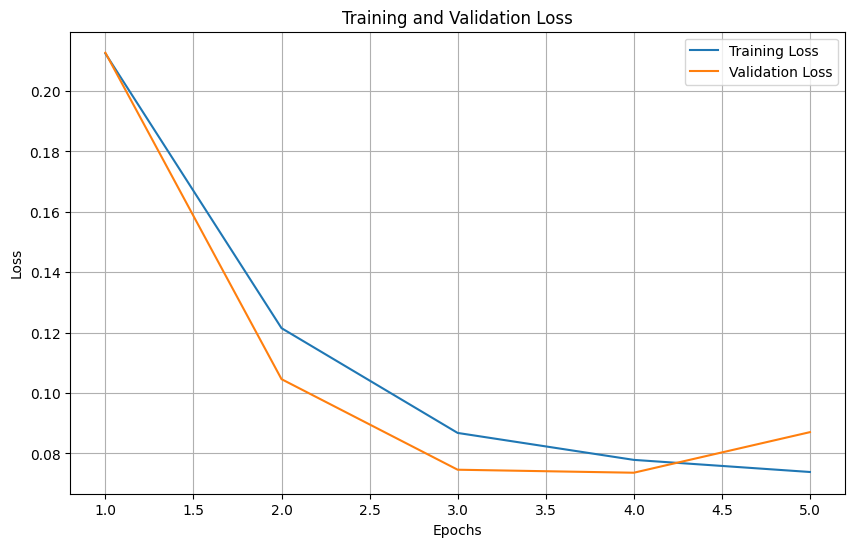

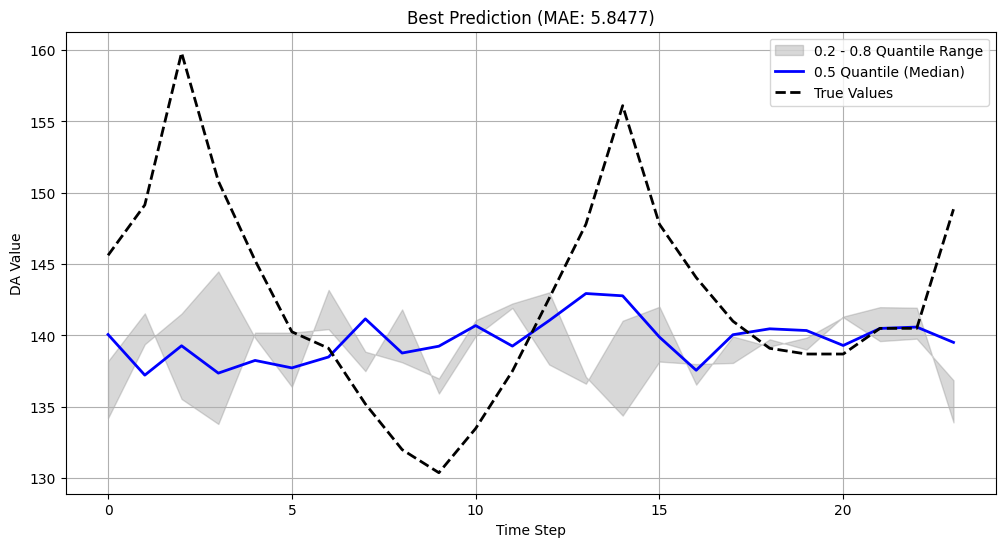

MAE: 5.8477
Pinball Loss: 9.4186
Coverage: 0.1250


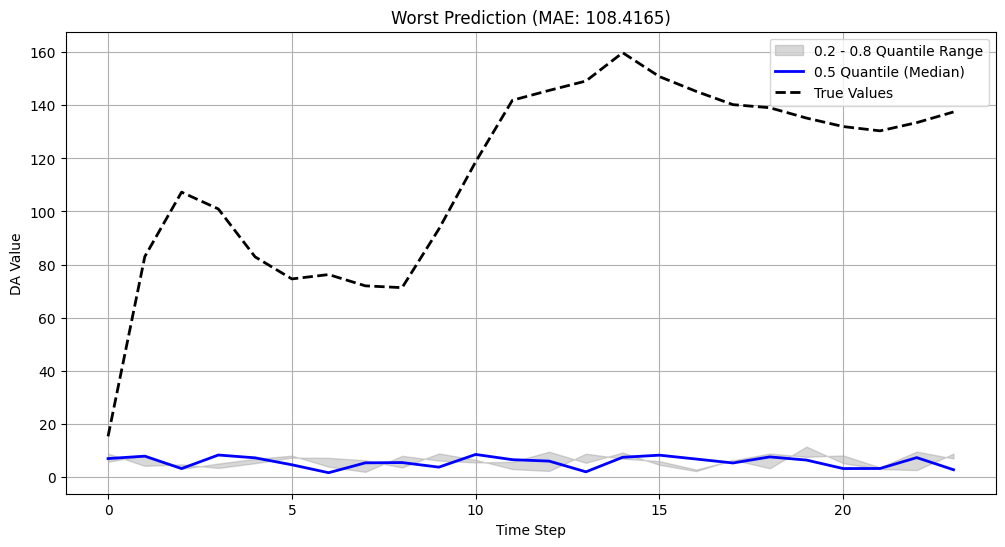

MAE: 108.4165
Pinball Loss: 162.3742
Coverage: 0.0000
Average MAE: 31.6169


In [5]:
# Train model
simple_model, train_losses, val_losses = train_and_val(
    train_loader, val_loader, num_epochs=5, model=model1, optimizer=optimizer1, quantiles=quantiles, device=device
)
# # Predict
forecast_inv, true_inv = predict_model(simple_model, test_loader, target_scaler, quantiles=quantiles, forecast_horizon=24, device=device)

# # Plot results
plot_forecasts(forecast_inv, true_inv, quantiles=quantiles, forecast_horizon=24)

# 3 Spaced Models for DA, ID and Diff

In [6]:
# Parameters
dense_lookback = 168
spaced_lookback = 180*24
target_cols = ["DA", "ID", "Diff"]

In [7]:
def train_and_val(train_loader, val_loader, num_epochs, model, optimizer, quantiles, device):
    """
    Train and validate the SpacedLSTM model using dense, spaced, and future data.
    
    Args:
        train_loader (DataLoader): DataLoader for training data.
        val_loader (DataLoader): DataLoader for validation data.
        num_epochs (int): Number of epochs for training.
        model (nn.Module): The SpacedLSTM model to train.
        optimizer (torch.optim.Optimizer): Optimizer for model training.
        quantiles (list): List of quantiles for loss calculation.
        device (torch.device): Device to run training on ('cpu' or 'cuda').
    
    Returns:
        model (nn.Module): The trained model.
        train_losses (list): List of average training losses per epoch.
        val_losses (list): List of average validation losses per epoch.
    """
    train_losses, val_losses = [], []

    for epoch in range(1, num_epochs + 1):
        # Training Phase
        model.train()
        epoch_train_loss = 0
        for batch_idx, (dense_inputs, spaced_inputs, future_inputs, pca_inputs, targets) in enumerate(train_loader):
            # Move data to the specified device
            dense_inputs, spaced_inputs, future_inputs, pca_inputs, targets = (
                dense_inputs.to(device).float(),
                spaced_inputs.to(device).float(),
                future_inputs.to(device).float(),
                pca_inputs.to(device).float(),
                targets.to(device).float(),
            )

            # Forward pass
            optimizer.zero_grad()
            forecasts = model(dense_inputs, spaced_inputs, future_inputs, pca_inputs)

            # Calculate loss
            loss = quantile_loss(targets, forecasts, quantiles)

            # Backpropagation and optimization
            loss.backward()
            optimizer.step()
            epoch_train_loss += loss.item()

        # Average training loss for the epoch
        epoch_train_loss /= len(train_loader)
        train_losses.append(epoch_train_loss)

        # Validation Phase
        model.eval()
        epoch_val_loss = 0
        with torch.no_grad():
            for batch_idx, (dense_inputs, spaced_inputs, future_inputs, pca_inputs, targets) in enumerate(val_loader):
                # Move data to the specified device
                dense_inputs, spaced_inputs, future_inputs, pca_inputs, targets = (
                    dense_inputs.to(device).float(),
                    spaced_inputs.to(device).float(),
                    future_inputs.to(device).float(),
                    pca_inputs.to(device).float(),
                    targets.to(device).float(),
                )

                # Forward pass
                forecasts = model(dense_inputs, spaced_inputs, future_inputs, pca_inputs)

                # Calculate loss
                loss = quantile_loss(targets, forecasts, quantiles)
                epoch_val_loss += loss.item()

        # Average validation loss for the epoch
        epoch_val_loss /= len(val_loader)
        val_losses.append(epoch_val_loss)

        # Log epoch results
        print(
            f"Epoch [{epoch}/{num_epochs}], Training Loss: {epoch_train_loss:.4f}, Validation Loss: {epoch_val_loss:.4f}"
        )

    # Plot Training and Validation Losses
    plot_training_validation_loss(train_losses, val_losses)

    return model, train_losses, val_losses

usable_hours: 12455
Epoch [1/25], Training Loss: 0.7104, Validation Loss: 0.2088
Epoch [2/25], Training Loss: 0.1908, Validation Loss: 0.1331
Epoch [3/25], Training Loss: 0.1440, Validation Loss: 0.1261
Epoch [4/25], Training Loss: 0.1327, Validation Loss: 0.1110
Epoch [5/25], Training Loss: 0.1271, Validation Loss: 0.1076
Epoch [6/25], Training Loss: 0.1231, Validation Loss: 0.1053
Epoch [7/25], Training Loss: 0.1194, Validation Loss: 0.1042
Epoch [8/25], Training Loss: 0.1162, Validation Loss: 0.1061
Epoch [9/25], Training Loss: 0.1132, Validation Loss: 0.1144
Epoch [10/25], Training Loss: 0.1087, Validation Loss: 0.1155
Epoch [11/25], Training Loss: 0.1039, Validation Loss: 0.1058
Epoch [12/25], Training Loss: 0.1003, Validation Loss: 0.1004
Epoch [13/25], Training Loss: 0.0973, Validation Loss: 0.1012
Epoch [14/25], Training Loss: 0.0943, Validation Loss: 0.1042
Epoch [15/25], Training Loss: 0.0925, Validation Loss: 0.1021
Epoch [16/25], Training Loss: 0.0895, Validation Loss: 0.10

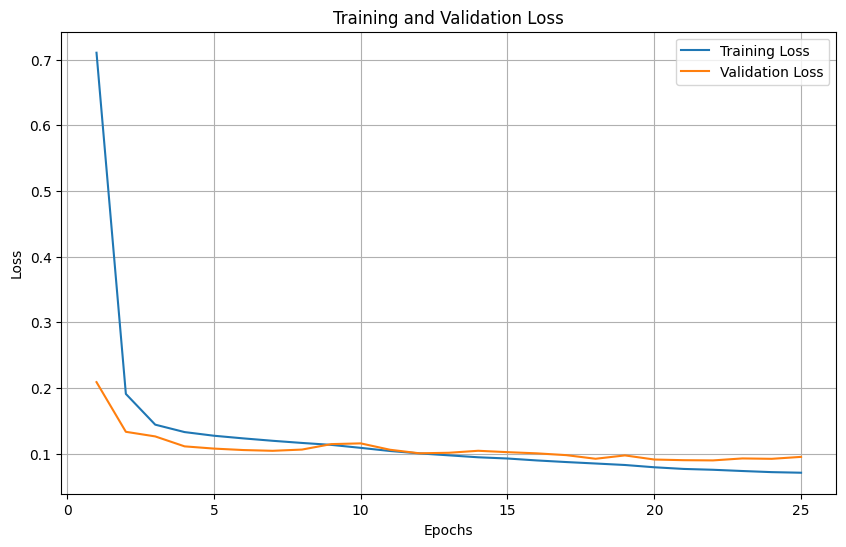

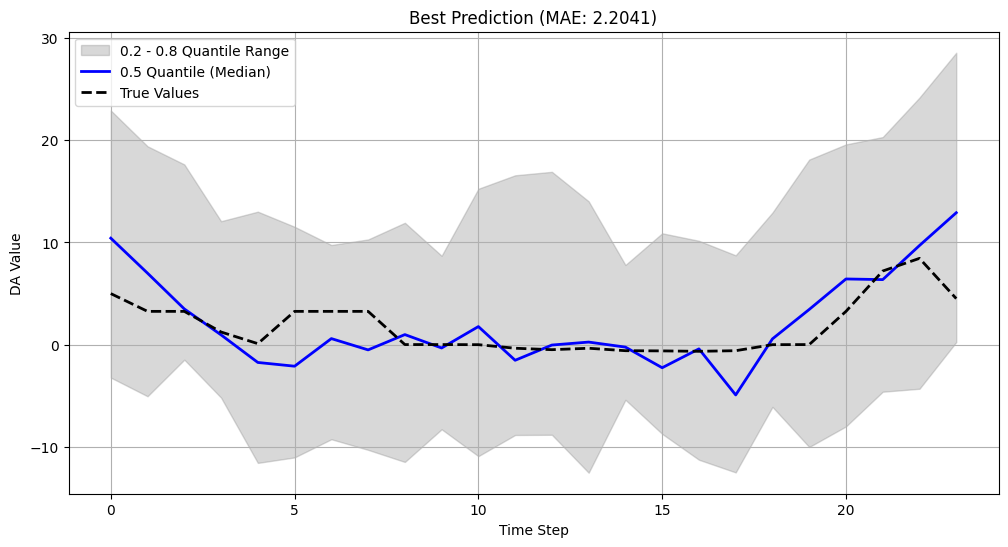

MAE: 2.2041
Pinball Loss: 5.6866
Coverage: 1.0000


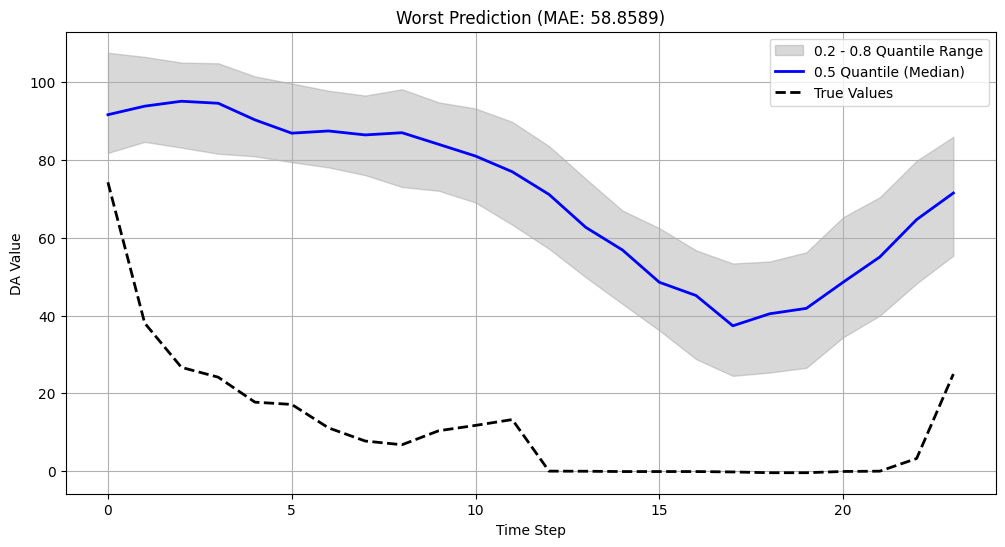

MAE: 58.8589
Pinball Loss: 80.6314
Coverage: 0.0000
Average MAE: 26.0287
usable_hours: 12455
Epoch [1/25], Training Loss: 0.7042, Validation Loss: 0.1371
Epoch [2/25], Training Loss: 0.1516, Validation Loss: 0.0864
Epoch [3/25], Training Loss: 0.1031, Validation Loss: 0.0846
Epoch [4/25], Training Loss: 0.0912, Validation Loss: 0.0771
Epoch [5/25], Training Loss: 0.0854, Validation Loss: 0.0774
Epoch [6/25], Training Loss: 0.0816, Validation Loss: 0.0735
Epoch [7/25], Training Loss: 0.0791, Validation Loss: 0.0769
Epoch [8/25], Training Loss: 0.0767, Validation Loss: 0.0766
Epoch [9/25], Training Loss: 0.0756, Validation Loss: 0.0709
Epoch [10/25], Training Loss: 0.0741, Validation Loss: 0.0700
Epoch [11/25], Training Loss: 0.0723, Validation Loss: 0.0664
Epoch [12/25], Training Loss: 0.0707, Validation Loss: 0.0675
Epoch [13/25], Training Loss: 0.0694, Validation Loss: 0.0753
Epoch [14/25], Training Loss: 0.0677, Validation Loss: 0.0672
Epoch [15/25], Training Loss: 0.0657, Validation

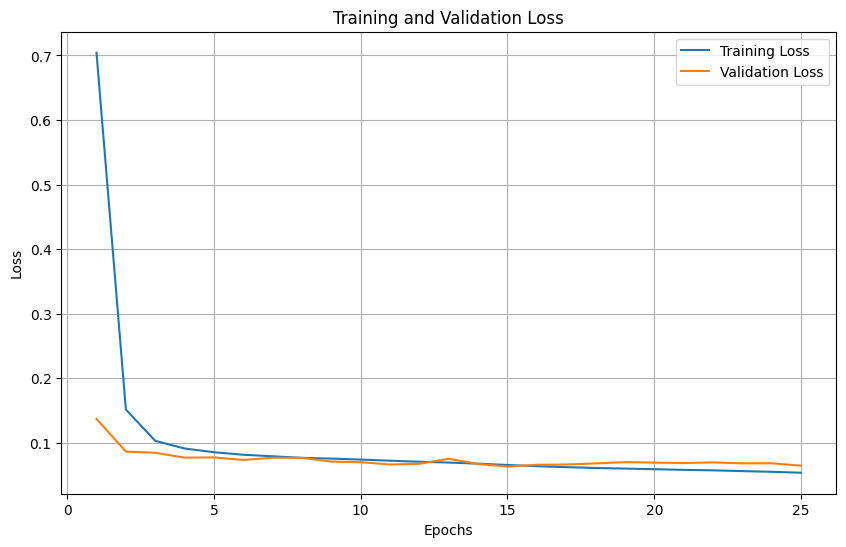

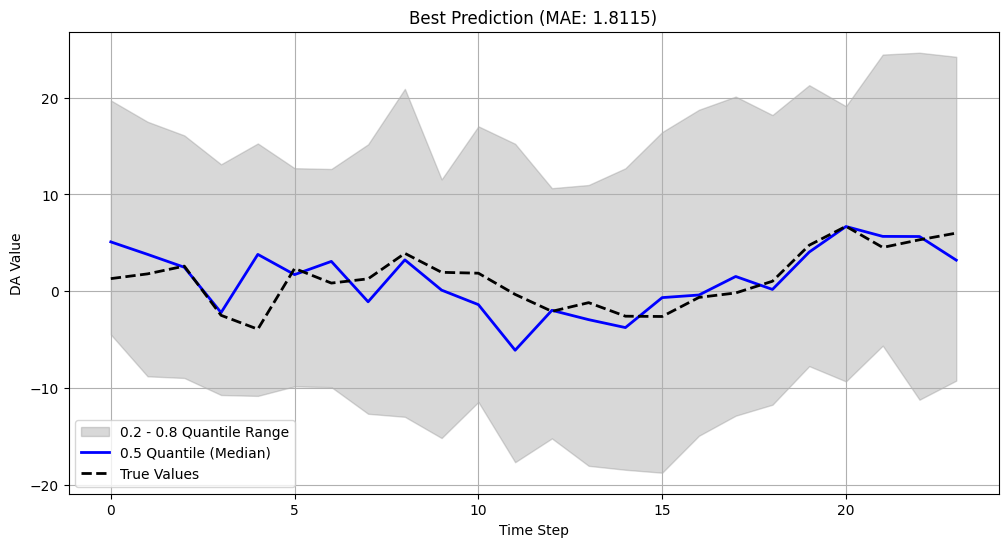

MAE: 1.8115
Pinball Loss: 6.6939
Coverage: 1.0000


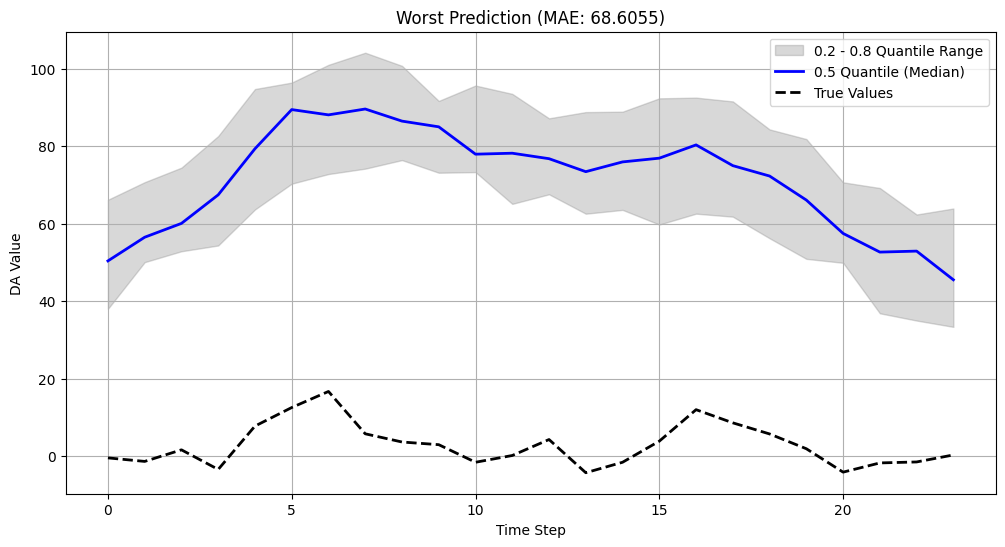

MAE: 68.6055
Pinball Loss: 95.3581
Coverage: 0.0000
Average MAE: 28.5202
usable_hours: 12455
Epoch [1/25], Training Loss: 0.6768, Validation Loss: 0.1215
Epoch [2/25], Training Loss: 0.1288, Validation Loss: 0.0627
Epoch [3/25], Training Loss: 0.0829, Validation Loss: 0.0563
Epoch [4/25], Training Loss: 0.0726, Validation Loss: 0.0582
Epoch [5/25], Training Loss: 0.0687, Validation Loss: 0.0577
Epoch [6/25], Training Loss: 0.0656, Validation Loss: 0.0626
Epoch [7/25], Training Loss: 0.0636, Validation Loss: 0.0641
Epoch [8/25], Training Loss: 0.0618, Validation Loss: 0.0635
Epoch [9/25], Training Loss: 0.0599, Validation Loss: 0.0665
Epoch [10/25], Training Loss: 0.0585, Validation Loss: 0.0656
Epoch [11/25], Training Loss: 0.0576, Validation Loss: 0.0640
Epoch [12/25], Training Loss: 0.0569, Validation Loss: 0.0681
Epoch [13/25], Training Loss: 0.0563, Validation Loss: 0.0669
Epoch [14/25], Training Loss: 0.0560, Validation Loss: 0.0698
Epoch [15/25], Training Loss: 0.0556, Validation

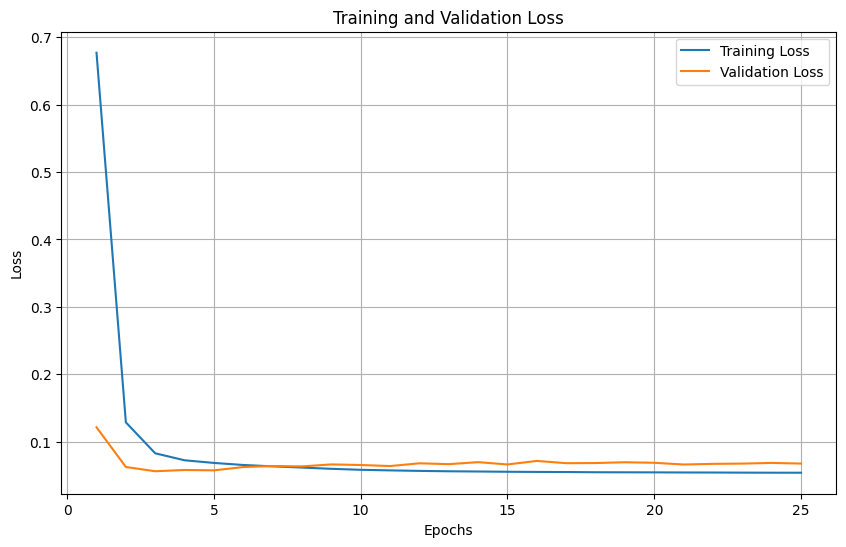

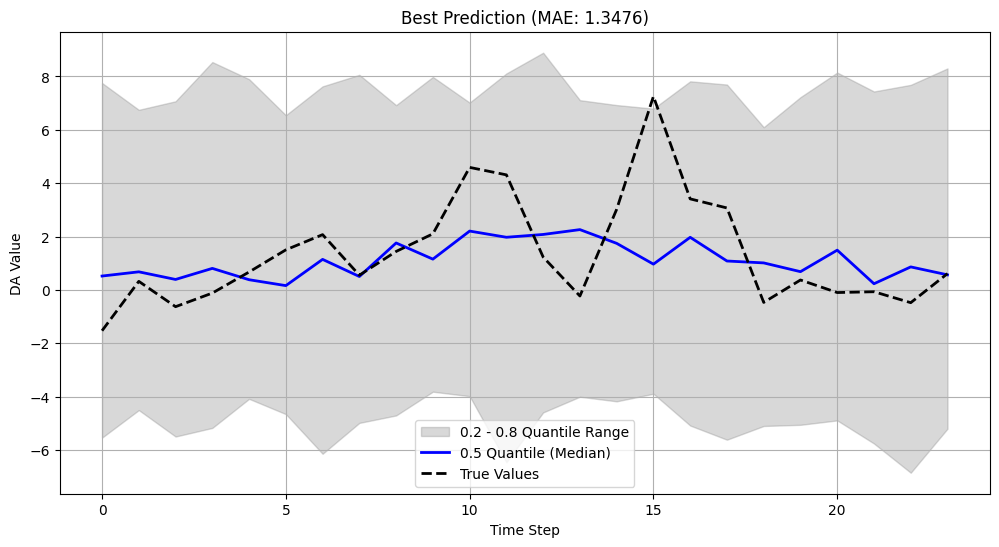

MAE: 1.3476
Pinball Loss: 3.1940
Coverage: 0.9583


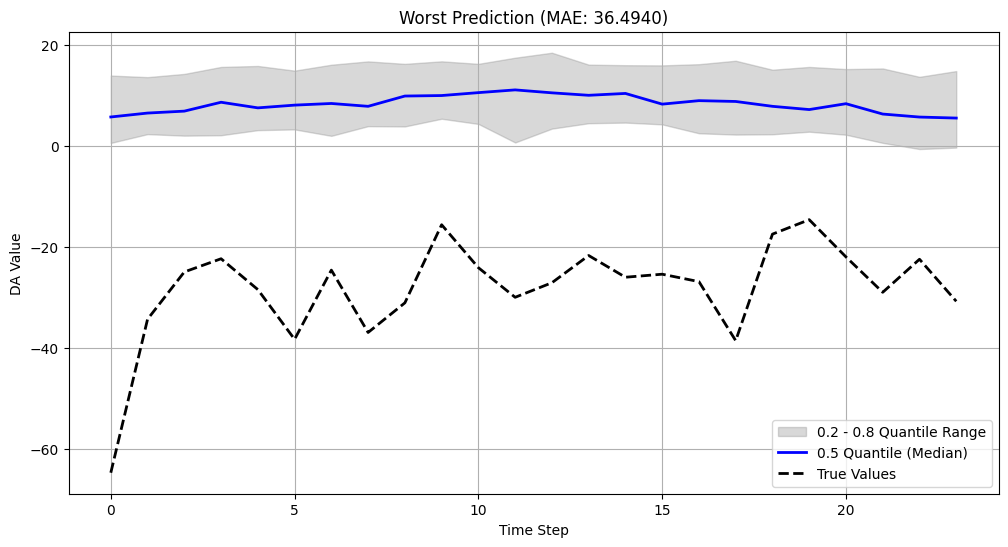

MAE: 36.4940
Pinball Loss: 51.6637
Coverage: 0.0000
Average MAE: 8.2122


In [8]:

for target_col in target_cols:
    print("--------------------------------------------------")
    print(f"Training model for target: {target_col}")
    print("--------------------------------------------------")
    # Prepare datasets with dense and spaced inputs
    (
        train_dense_past,
        train_spaced_past,
        train_future,
        train_pca,
        train_targets,
        val_dense_past,
        val_spaced_past,
        val_future,
        val_pca,
        val_targets,
        test_dense_past,
        test_spaced_past,
        test_future,
        test_pca,
        test_targets,
        target_scaler,
    ) = prepare_data(
        file_path=file_path,
        dense_lookback=dense_lookback,
        spaced_lookback=spaced_lookback,
        forecast_horizon=forecast_horizon,
        future_cols=future_cols,
        target_col=target_col,
        spaced=True,
        step_growth_factor=1,
    )

    # Create DataLoaders
    train_loader = DataLoader(
        list(zip(train_dense_past, train_spaced_past, train_future, train_pca, train_targets)),
        batch_size=64,
        shuffle=True,
    )
    val_loader = DataLoader(
        list(zip(val_dense_past, val_spaced_past, val_future, val_pca, val_targets)),
        batch_size=64,
        shuffle=False,
    )
    test_loader = DataLoader(
        list(zip(test_dense_past, test_spaced_past, test_future, test_pca, test_targets)),
        batch_size=1,
        shuffle=False,
    )

    # Initialize model
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model2 = SpacedLSTM(
        dense_input_size=train_dense_past.shape[2],
        spaced_input_size=train_spaced_past.shape[2],
        future_input_size=len(future_cols),
        pca_input_size=train_pca.shape[1],
        hidden_size=128,
        num_layers=2,
        dropout=0.3,
        dense_horizons=dense_lookback,
        spaced_horizons=train_spaced_past.shape[1],
        forecast_horizon=forecast_horizon,
        quantiles=quantiles,
    ).to(device)

    # Optimizer
    optimizer2 = torch.optim.AdamW(model2.parameters(), lr=0.0005, weight_decay=1e-4)

    # Train model
    spaced_model, train_losses, val_losses = train_and_val(
        train_loader, val_loader, num_epochs=25, model=model2, optimizer=optimizer2, quantiles=quantiles, device=device
    )
    # # Predict
    forecast, true = predict_model(spaced_model, test_loader, target_scaler, quantiles=quantiles, forecast_horizon=24, device=device, spaced=True)

    # # Plot results
    plot_forecasts(forecast, true, quantiles=quantiles, forecast_horizon=24)
